# Cluster Search

### Connect to Goog`le Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### import the libraries

In [2]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from scipy.spatial.distance import cdist

### pre-trained ResNet-50 Model

In [3]:
BACKBONE = 'resnet50'
class ResNetFreezed(nn.Module):
    def __init__(self, freeze_param=True):
        super(ResNetFreezed, self).__init__()
        if BACKBONE == "resnet34":
            self.backbone = torchvision.models.resnet34(pretrained=True)
        if BACKBONE == "resnet50":
            self.backbone = torchvision.models.resnet50(pretrained=True)
        if BACKBONE == "resnet101":
            self.backbone = torchvision.models.resnet101(pretrained=True)
        state_dict = self.backbone.state_dict()
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        
        if freeze_param:
            for param in self.backbone.parameters():
                param.requires_grad = False

        
    def forward(self, x):
        x = self.backbone(x)
        out = torch.flatten(x, 1)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetFreezed().to(device)
model.eval()

cifar10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
bs = 4
transform = transforms.Compose(
    [transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def unnormalize(img):
    img = (img * 0.5) + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

train_dataset = torchvision.datasets.CIFAR10(root='gdrive/MyDrive/data/cifar-10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs,
                                          shuffle=True, num_workers=0)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Files already downloaded and verified


### Load the Embedding
 - Load the embedding .pkl extension file.

In [4]:
df_embeddings = pd.read_pickle('gdrive/MyDrive/data/cifar10_resnet50_imagenet_embeddings.pkl')

In [5]:
from sklearn.cluster import KMeans
import joblib
import os

In [6]:
features = list(df_embeddings.vec)
kmeans_model = KMeans(n_clusters=10, random_state=1).fit(features)


In [7]:
joblib.dump(kmeans_model, 'gdrive/MyDrive/models/kmeans_v1.m')
#kmeans_model = joblib.load('gdrive/MyDrive/models/kmeans_v1.m')

['gdrive/MyDrive/models/kmeans_v1.m']

In [20]:

target_idx = random.randint(0,len(train_dataset))
target = train_dataset[target_idx][0]
target_label = cifar10_classes[train_dataset[target_idx][1]]
target_tensor = torch.unsqueeze(train_dataset[target_idx][0], 0).to(device)

In [21]:
feat = model(target_tensor).detach().cpu()
feat.shape

torch.Size([1, 2048])

In [22]:
label = kmeans_model.predict(feat[0].reshape(1, feat[0].shape[0]))
selected_ind = np.where(kmeans_model.labels_ == label)
d_feats = df_embeddings.iloc[selected_ind].vec

In [23]:
top_n = 5
dist = cdist(feat, list(d_feats.values), 'euclidean')[0]
ind = np.argpartition(dist, top_n)[:top_n]
ind

array([2730, 3631, 1900, 2384,  568])

### Visualize the top images

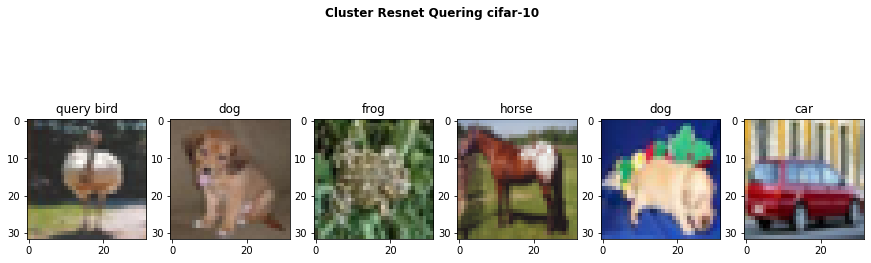

In [24]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle('Cluster Resnet Quering cifar-10', fontweight ="bold")
no_of_images = top_n+1

ax = fig.add_subplot(1, no_of_images, 1)
ax.imshow(unnormalize(target))
ax.set_title('query {}'.format(target_label))

for i in range(1, no_of_images):
    ax = fig.add_subplot(1, no_of_images, i+1)
    ax.imshow(unnormalize(train_dataset[ind[i-1]][0]))
    ax.set_title('{}'.format(cifar10_classes[train_dataset[ind[i-1]][1]]))

**Thank you**